### Infinite variance
1. 문제: 좌, 우로만 일정한 확률로 움직일 수 있는 상황에서 terminal에 도달하는 게임이다. 
2. 조건
    - state: 위치가 현 상태 혹은 terminal 밖에 없으므로 따로 표현하지 않아도 된다.
    - action:
        - right: 바로 terminal에 도달한다. 
        - left: 0.1의 확률로 terminal 도달, 0.9의 확률로 원래 자리로 돌아온다. 
    - reward:
        - terminal 도달한 경우: right(0), left(+1)
        - 그 외: 0
3. 학습 목표
    - Off-policy estimation

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
LEFT = 0
RIGHT = 1

def up_or_down():
    return np.random.choice([0, 1], p=[0.9, 0.1])

def behavior_policy():
    return [0.5, 0.5]

def target_policy():
    return [1.0, 0]

def step(action):   
    reward = 0
    done = False
    if action == RIGHT:
        done = True
    else:
        if up_or_down():
            reward = 1
            done = True
        else:
            done = False
    return [reward, done]

#### Off-policy MC prediction
아래 2개 식에 대한 문제를 푼다. $T(t)$는 episode 내에서의 $t$ step을 의미하고 $\Im(s)$는 모든 state 방문에 대한 time step을 모아놓은 항이다. 이 문제에서는 state가 없으므로 1 episode 당 1개의 state만 방문한다고 생각하자.

$$
\begin{align} 
\rho_{t:T-1} &\doteq \dfrac {\prod_{k=t}^{T-1} \pi(a_k \lvert S_k) p(S_{k+1} \lvert S_k, A_k)} {\prod_{k=t}^{T-1} b(A_k \lvert S_k)p(S_{k+1} \lvert S_k, A_k)} = \prod_{k=t}^{T-1} \dfrac {\pi(A_k \lvert S_k)} {b(A_k \lvert S_k)} \\
V(s) &\doteq \dfrac {\sum_{t \in \Im(s)} \rho_{t:T(t)-1} G_t} {\lvert \Im(s) \rvert}
\end{align}$$

![off policy mc pred](../images/off_policy_mc_prediction.png)
<center> 출처: Reinforcement Learning : An Introduction. Richard S. Sutton and Andrew G. Barto. 2017 (pp. 90) </center>

In [15]:
def off_policy_mc_prediction(num_episodes, num_runs, discount_factor=1.0):
    axisX = np.log10(np.arange(1, num_episodes + 1))
    for i_run in range(num_runs):
        reward_sum = [0]
        b_policy = behavior_policy()
        t_policy = target_policy()

        for i_episode in range(num_episodes):
            trajectories = 0
            if i_episode % 1000 == 0:
                print("\rRun {}/{} Episode {}/{}.".format(i_run + 1, num_runs, i_episode, num_episodes), end="")
            while True:
                # action을 하고 오른쪽, 왼쪽으로 나가거나 다시 loop를 돌아야 한다. (trajectory +1)
                action = np.random.choice(2, p=b_policy)
                reward, done = step(action)
                trajectories += 1
                if done:
                    break        
            if reward:
                importance_ratio = pow(2, trajectories) # 왜 pow(0.5, trajectory) 이지?
            else:
                importance_ratio = 0        
            reward_sum.append(reward_sum[-1] + importance_ratio * reward)
        del reward_sum[0]
        V = np.asarray(reward_sum) / np.arange(1, num_episodes + 1)
        plt.plot(axisX, V)
    plt.xlabel('Episodes (10^x)')
    plt.ylabel('Ordinary Importance Sampling')
    plt.ylim(0, 5)
    plt.show()
    return V

Run 10/10 Episode 99000/100000.

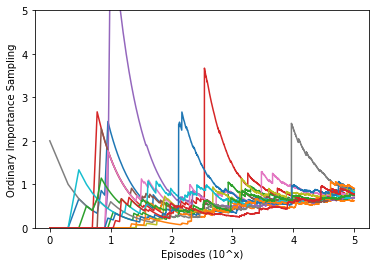

In [16]:
V = off_policy_mc_prediction(100000, 10)